## 1. Introduction

This notebook analyzes grocery prices in Vietnam and Russia.  
Below, we import libraries and define constants, including supermarket names, product categories, and exchange rates.

In [43]:
import pandas as pd
import math as m
import matplotlib.pyplot as plt

# sets of supermarkets by country
viet_super = {'Winmart', 'Co.op'}
rus_super = {'Pyaterochka', 'Lenta'}

# sets of categories grouped by quantity type or product type
all_categories = {'bread', 'cucumber', 'tomato', 'cabbage', 'onion', 'carrot', 'eggplant', 'banana',
                  'orange', 'mango', 'milk', 'condensed_milk', 'tofu', 'egg', 'yogurt', 'pork_leg',
                  'chicken_fillet', 'spaghetti', 'buckwheat', 'rice', 'black_tea', 'sugar', 'green_tea',
                  'ground_coffee', 'salt', 'sunflower_oil', 'water', 'fish_sauce', 'rice_noodles',
                  'soybean_oil', 'water_spinach'}
per_lit_categories = {'fish_sauce', 'milk', 'water', 'sunflower_oil', 'soybean_oil'}
per_piece_categories = {'egg'}
per_kg_categories = all_categories - per_lit_categories - per_piece_categories
vegetables = {'cucumber', 'tomato', 'cabbage', 'onion', 'carrot', 'eggplant', 'water_spinach'}
fruit = {'banana', 'orange', 'mango'}
staples = {'spaghetti', 'buckwheat', 'rice', 'rice_noodles'}
oils = {'sunflower_oil', 'soybean_oil'}
dairy = {'milk', 'yogurt'}
meat = {'pork_leg', 'chicken_fillet'}
drinks = {'green_tea', 'black_tea', 'ground_coffee'}

exchange_rates = {
    'Vietnam': 0.000039214,
    'Russia': 0.011056 
}

## 2. Data Preparation

We import the cleaned CSV file and reorganize the table to make it more analysis-friendly.  
This includes:
- Adding a 'country' column based on supermarket
- Renaming and reordering columns
- Merging name and unit of measure into a single string (like "*name (uom)*")
- Normalizing all units (kg, liter, unit) for comparability
- Merging quantity columns and their respective price columns
- Converting prices to USD
- Dropping or correcting specific entries

In [44]:
clean_products = pd.read_csv('clean_products-2025-03-12-local.csv')

In [45]:
# add 'country' column based on supermarket name
clean_products['country'] = clean_products.supermarket.apply(lambda x: 'Vietnam' if x in viet_super else 'Russia') 

# rename price and product_type columns
clean_products = clean_products.rename(columns={'price': 'supermarket_price', 'product_type': 'product_category'})

# combine 'name' and 'uom' into a single 'product_name' column
clean_products['product_name'] = clean_products.name + ' (' + clean_products.uom.fillna('') + ')'

In [46]:
# assign a standard unit of measurement (kg, l, piece) based on product category
def assign_unit(product_category):
    if product_category in per_lit_categories:
        return 'l'
    elif product_category in per_piece_categories:
        return 'piece'
    else:
        return 'kg'

clean_products['unit'] = clean_products.product_category.apply(assign_unit)

In [47]:
# merge weight/volume/unit counts into a single 'quantity' column, converting g → kg and ml → l
clean_products['quantity'] = clean_products[['weight', 'number_of_units', 'volume']].apply(lambda row: row.dropna().values[0], axis=1)
clean_products.loc[clean_products.unit.isin(['kg', 'l']), 'quantity'] /= 1000

# merge normalized price columns into a single 'normalized_price' column
clean_products['normalized_price'] = clean_products[['price_kg', 'price_unit', 'price_lit']].apply(lambda row: row.dropna().values[0], axis=1)

In [48]:
# convert prices to USD, add supermarket_price_usd column
clean_products['supermarket_price_usd'] = clean_products.supermarket_price * clean_products.country.map(exchange_rates)
clean_products['normalized_price'] = clean_products.normalized_price * clean_products.country.map(exchange_rates)

In [49]:
# reorganize and keep only relevant columns
clean_products = clean_products.iloc[:, [12, 5, 4, 13, 2, 17, 15, 14, 16]]

In [50]:
# add a missing buckwheat entry for Vietnam (Winmart)
clean_products.loc[3000] = ['Vietnam', 'Winmart', 'buckwheat', 'Hạt kiều mạch hiệu Goodwill', 85600, 3.3567184, 0.8, 'kg', 4.195898]
# remove an incorrect chicken fillet entry
clean_products = clean_products.drop(428)

The dataset is now cleaned and formatted for analysis. Quick inspection:

In [51]:
clean_products
# save to CSV
# clean_products.to_csv('total-products-list.csv', index=False)

,country,supermarket,product_category,product_name,supermarket_price,supermarket_price_usd,quantity,unit,normalized_price
0,Russia,Pyaterochka,bread,Багет традиционный 230г (230 г),45.99,0.508465,0.23,kg,2.210719
1,Russia,Pyaterochka,bread,Багет Фитнес 200г (200 г),49.99,0.552689,0.20,kg,2.763447
2,Russia,Pyaterochka,bread,Багет мини 120г (120 г),25.99,0.287345,0.12,kg,2.394545
3,Russia,Pyaterochka,bread,Хлеб Маг с семечками 390г (390 г),75.99,0.840145,0.39,kg,2.154219
4,Russia,Pyaterochka,cucumber,Огурцы среднеплодные (Цена за 1 кг),175.99,1.945745,1.00,kg,1.945745
...,...,...,...,...,...,...,...,...,...
2195,Vietnam,Co.op,rice,Gạo thơm ST25 plus lúa tôm Neptune 5kg (bịch),252000.00,9.881928,5.00,kg,1.976386
2196,Vietnam,Co.op,orange,Cam sành Coop Select túi kg (kg),24900.00,0.976429,1.00,kg,0.976429
2197,Vietnam,Co.op,condensed_milk,Sữa đặc Dutch Lady cao cấp lon 380g – KM (lon),32400.00,1.270534,0.38,kg,3.343509
2198,Vietnam,Co.op,eggplant,Cà tím màng co (kg),25500.00,0.999957,1.00,kg,0.999957


## 3. Exploratory Data Analysis (EDA)

### 3.1. General Overview

Before diving into detailed comparisons, let’s explore the general structure of the dataset. We’ll examine the total number of products and how they’re distributed across countries, supermarkets, and product categories.

#### Total Number of Products

Count all unique entries in the dataset after cleaning.

In [52]:
total_count = len(clean_products)
total_count

2199

#### Product Distribution by Country

This shows how many products come from Vietnam vs. Russia.

In [53]:
count_by_country = clean_products.groupby('country').product_name.count()
count_by_country = count_by_country.reset_index()
count_by_country.columns = ['country', 'count']
# count_by_country.to_csv('total-count-by-country.csv', index=False)
count_by_country

,country,count
0,Russia,1372
1,Vietnam,827


#### Product Distribution by Supermarket

Useful for identifying which supermarkets contribute the most data.

In [54]:
count_by_supermarket = clean_products.groupby('supermarket').product_name.count()
count_by_supermarket = count_by_supermarket.reset_index()
count_by_supermarket.columns = ['supermarket', 'count']
# count_by_supermarket.to_csv('total-count-by-supermarket.csv', index=False)
count_by_supermarket

,supermarket,count
0,Co.op,615
1,Lenta,962
2,Pyaterochka,410
3,Winmart,212


#### Product Distribution by Category

This gives insight into which types of products dominate the dataset.

In [55]:
count_by_category = clean_products.groupby('product_category').product_name.count()
count_by_category = count_by_category.reset_index()
count_by_category.columns = ['product_category', 'count']
# count_by_category.to_csv('total-count-by-category.csv', index=False)
count_by_category

,product_category,count
0,banana,13
1,black_tea,290
2,bread,164
3,buckwheat,33
4,cabbage,6
5,carrot,12
6,chicken_fillet,18
7,condensed_milk,55
8,cucumber,26
9,egg,77


#### Product Distribution by Supermarket & Category

Combining supermarket and category provides a more granular view of product availability.

In [56]:
count_by_supermarket_category = clean_products.groupby(['supermarket', 'product_category']).product_name.count()
count_by_supermarket_category = count_by_supermarket_category.reset_index()
count_by_supermarket_category.columns = ['supermarket', 'product_category', 'count']
# count_by_supermarket_category.to_csv('total-count-by-supermarket-category.csv', index=False)
count_by_supermarket_category

,supermarket,product_category,count
0,Co.op,banana,5
1,Co.op,black_tea,14
2,Co.op,bread,13
3,Co.op,cabbage,2
4,Co.op,carrot,4
...,...,...,...
112,Winmart,tofu,3
113,Winmart,tomato,6
114,Winmart,water,10
115,Winmart,water_spinach,3


### 3.2. Outliers check, summary and basic plots

#### Overview & Strategy

Before we proceed with statistical summaries and plots, it's important to address potential outliers, which could distort the results.

Key Notes:  
- Price distributions vary significantly by category, ranging from roughly normal to clustered or sparse.
- Therefore, outlier handling is customized per category:
    1. Close to normal or skewed distributions → outliers removed using IQR on log-transformed prices.
    2. Clustered distributions or too few data points → outlier removal skipped.
    3. Final decision is based on visual inspection of price histograms.
- Median is used for comparison instead of mean due to frequent skewness in price data.

#### Step 1: Initial Histograms for Visual Inspection

We start by plotting histograms for each product category to evaluate the distribution in Russia and Vietnam. These plots guide whether outlier removal is needed.

In [57]:
# initialize a dictionary to store filtered data, plots, and summary statistics by category
data_summary = {}

for category in all_categories:
    
    # filter data for the current category and select relevant columns
    category_data = clean_products[clean_products.product_category == category]
    category_data = category_data.iloc[:, [0, 1, 2, 3, 8]]
    category_data_ru = category_data.loc[category_data.country == 'Russia']
    category_data_vn = category_data.loc[category_data.country == 'Vietnam']

    # determine number of bins for histograms using sqrt rule
    bins_ru = 1 if len(category_data_ru) == 0 else m.ceil(m.sqrt(len(category_data_ru)))
    bins_vn = 1 if len(category_data_vn) == 0 else m.ceil(m.sqrt(len(category_data_vn)))
    
    # plot histograms of normalized prices for each country
    fig, (ax1, ax2) = plt.subplots(2, 1)
    category_data_ru.normalized_price.hist(bins=bins_ru, ec='k', ax=ax1)
    ax1.set_title('Russia')
    category_data_vn.normalized_price.hist(bins=bins_vn, ec='k', ax=ax2)
    ax2.set_title('Vietnam')
    plt.tight_layout()
    plt.close('all')
    
    # store the histogram in the summary dictionary
    data_summary[category] = {
        'hist': fig
    }

Quick example inspection:

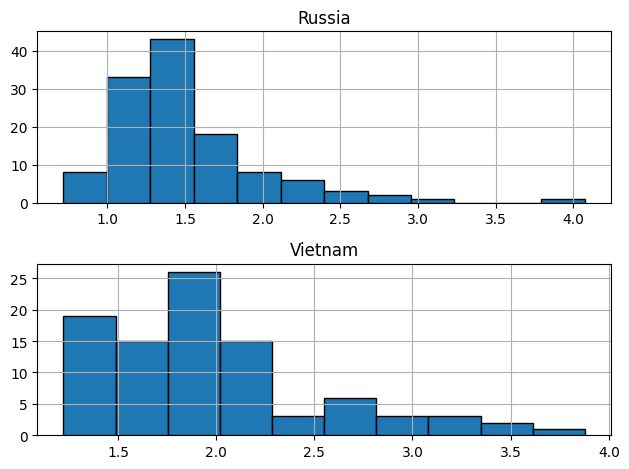

In [58]:
display(data_summary['milk']['hist'])

#### Step 2: Define Categories Where Outliers Are Skipped

Outlier removal is skipped for the categories listed below because:
- their price distributions show distinct clusters, or
- they contain too few data points for meaningful IQR filtering,  

which was assessed on the previous step.

In [59]:
skip_outliers_ru = ['banana', 'eggplant', 'tomato', 'ground_coffee', 'fish_sauce', 'condensed_milk',
                    'yogurt', 'carrot', 'cucumber', 'water_spinach', 'soybean_oil']
skip_outliers_vn = ['black_tea', 'eggplant', 'tomato', 'ground_coffee', 'chicken_fillet', 'condensed_milk',
                    'yogurt', 'carrot', 'cabbage', 'buckwheat', 'tofu']

#### Step 3: Functions for Outlier Detection and Summary Stats

To detect outliers, we use the IQR method on log-transformed prices. The IQR (stands for interquartile range) is the range between the first (Q1) and third (Q3) quartiles. Any value falling below Q1 − 1.5×IQR or above Q3 + 1.5×IQR is considered an outlier.

In [60]:
# the function identifies outliers and flags them in the 'is_outlier' column

def outliers_check(data):

    # apply log10 transformation to prices
    data['log_price'] = data.normalized_price.apply(m.log10)    # log10 for prices

    # calculate Q1, Q3, IQR, and outlier boundaries
    log_iqr = data.log_price.agg(          # Q1 and Q3
        q1=lambda x: x.quantile(0.25),
        q3=lambda x: x.quantile(0.75)
    )
    log_iqr['iqr'] = log_iqr.q3 - log_iqr.q1    # IQR
    log_iqr['lower_bound'] = log_iqr.q1 - log_iqr.iqr * 1.5
    log_iqr['upper_bound'] = log_iqr.q3 + log_iqr.iqr * 1.5     # boundaries
    
    # flag rows as outliers if they fall outside the bounds
    data['is_outlier'] = data.apply(
        lambda row: True if (row.log_price < log_iqr['lower_bound']) or (row.log_price > log_iqr['upper_bound']) else False,
        axis=1
    )

    # drop log_price column (no longer needed)
    data.drop(['log_price'], axis=1, inplace=True)

For each product category, a summary table is generated with key statistics by country: count, mean, standard deviation, median, quantiles (10th, 25th, 75th), IQR, min/max, and outlier counts and percentages (if applicable).

In [61]:
# the function returns count, mean and standard deviation, median, spread, and outlier stats by country

def summary_stats(data):

    # exclude outliers to ensure accurate statistics
    data_no_out = data.loc[~data['is_outlier']]
    
    # calculate statistics and aggregate them into a single DataFrame 
    summary = data_no_out.groupby('country').normalized_price.agg(
        count=lambda x: None, # placeholder, will be calculated below
        outliers=lambda x: None, # placeholder
        outliers_percent=lambda x: None, # placeholder
        average='mean',
        std='std',
        p10=lambda x: x.quantile(0.1),
        q1=lambda x: x.quantile(0.25),
        median='median',
        q3=lambda x: x.quantile(0.75),
        iqr=lambda x: x.quantile(0.75) - x.quantile(0.25),
        min='min',
        max='max',
    ).reset_index()

    # set 'country' as the index for easier access to country-level stats
    summary = summary.set_index('country')
    
    # fill missing 'count' and 'outliers' columns with aggregated values
    summary['count'] = data.groupby('country').product_name.count()
    summary['outliers'] = data.groupby('country').is_outlier.sum()
    summary['outliers_percent'] = summary['outliers'] / summary['count'] * 100
    
    return summary

#### Step 4: Full Analysis Loop for Each Category

With everything prepared, we now:

- Apply outlier removal (if needed): Outliers are excluded to ensure more accurate summary statistics and visualizations.
- Calculate key statistics such as the mean, median, and others.
- Generate plots:
    - Updated histogram (outliers excluded).
    - Bar plot of medians. This provides a clear visual comparison of the central values for each product category.
    - Box plot. The box plot displays the spread of the data, including the median, and IQR. It’s valuable for understanding the overall distribution of prices in both countries.
- Store everything in a dictionary for easy access (cleaned data, summary statistics, and visualizations).

In [62]:
# loop through all categories and process data
for category in all_categories:

    # extract and clean data for the selected category
    category_data = clean_products[clean_products.product_category == category]
    category_data = category_data.iloc[:, [0, 1, 2, 3, 8]]
    category_data_ru = category_data.loc[category_data.country == 'Russia'].copy()
    category_data_vn = category_data.loc[category_data.country == 'Vietnam'].copy()

    # add 'is_outlier' column for both Russia and Vietnam, default to False
    category_data_ru['is_outlier'] = False
    category_data_vn['is_outlier'] = False

    # outliers check for Russia (if applicable)
    if (category not in skip_outliers_ru) and (len(category_data_ru) > 0):
        outliers_check(category_data_ru)
        
    # outliers check for Vietnam (if applicable)
    if (category not in skip_outliers_vn)  and (len(category_data_vn) > 0):
        outliers_check(category_data_vn)

    # combine Russia and Vietnam data for simpler summarization
    category_data = pd.concat([category_data_ru, category_data_vn])   # combine for simpler summarization
    
    # generate summary statistics table for the category
    category_summary = summary_stats(category_data)
    
    # store data without outliers for plotting
    category_data_ru_no_out = category_data_ru.loc[~category_data_ru['is_outlier']]
    category_data_vn_no_out = category_data_vn.loc[~category_data_vn['is_outlier']]
    
    # calculate bin sizes for histograms
    bins_ru = 1 if len(category_data_ru_no_out) == 0 else m.ceil(m.sqrt(len(category_data_ru_no_out)))
    bins_vn = 1 if len(category_data_vn_no_out) == 0 else m.ceil(m.sqrt(len(category_data_vn_no_out)))

    # plot updated histograms for both countries
    fig, (ax1, ax2) = plt.subplots(2, 1)
    category_data_ru_no_out.normalized_price.hist(bins=bins_ru, ec='k', ax=ax1)
    ax1.set_title('Russia')
    category_data_vn_no_out.normalized_price.hist(bins=bins_vn, ec='k', ax=ax2)
    ax2.set_title('Vietnam')
    plt.tight_layout()

    # update the histogram in the data dictionary
    data_summary[category]['hist'] = fig

    # create bar and box plots
    category_barplot = category_summary.T.loc[['median']].plot.bar(rot=0).figure   # note: summary table is transposed for barplot
    category_boxplot = category_data.boxplot(by='country', column='normalized_price', showfliers=False).figure
    plt.close('all')
    
    # update data_summary dictionary with all the collected data
    data_summary[category].update({
        'data_ru': category_data_ru,
        'data_vn': category_data_vn,
        'summary': category_summary,
        'barplot': category_barplot,
        'boxplot': category_boxplot
    })

    # optionally, save to CSV (if needed)
    # data_summary[category]['data_ru'].to_csv(f'{category}_data_ru.csv', index=False)
    # data_summary[category]['data_vn'].to_csv(f'{category}_data_vn.csv', index=False)
    # data_summary[category]['summary'].to_csv(f'{category}_summary_stats.csv')

#### Step 5: Export Final Data

In [ ]:
# combine all the products back into a single DataFrame and save for further reference
# all_products_final = pd.concat([pd.concat([data_summary[cat]['data_ru'], data_summary[cat]['data_vn']]) for cat in data_summary])
# all_products_final.to_csv('products-final.csv', index=False)

Quick inspection of example summary stats and plots:

In [63]:
display(data_summary['ground_coffee']['summary'])

,count,outliers,outliers_percent,average,std,p10,q1,median,q3,iqr,min,max
country,,,,,,,,,,,,
Russia,97,0,0.0,29.123122,11.163213,16.971383,22.067334,26.208469,33.642302,11.574969,11.054894,53.677611
Vietnam,38,0,0.0,16.489933,9.994061,7.733001,10.162539,12.956185,20.780537,10.617998,6.274240,50.037064


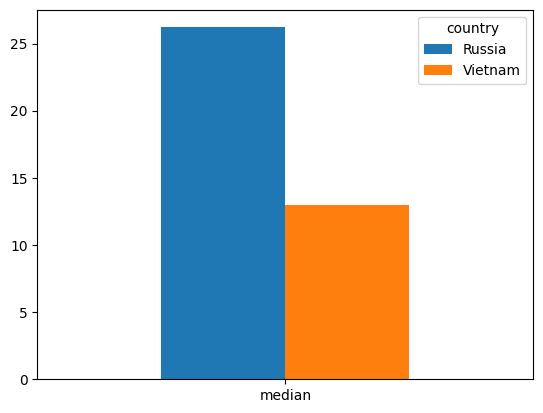

In [64]:
display(data_summary['ground_coffee']['barplot'])

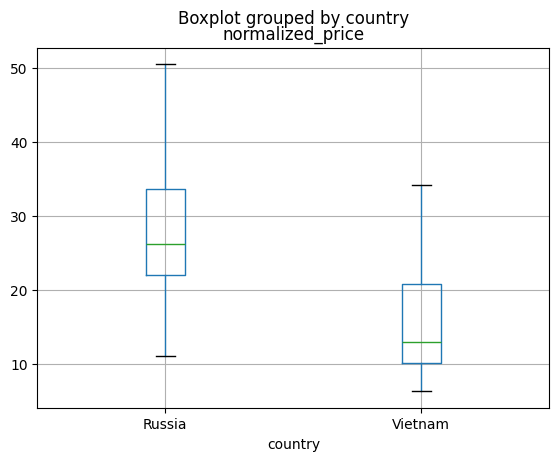

In [65]:
display(data_summary['ground_coffee']['boxplot'])

## 4. Comparative analysis

### 4.1. Price Comparison Summary

To compare normalized prices between Russia and Vietnam, as we already mentioned, medians are used as a robust measure of central tendency, less sensitive to outliers or skewed distributions.  
For each product category:
- Medians for Russia and Vietnam are extracted from the summary statistics tables.
- A VN/RU median ratio is calculated to quantify the difference in prices between the two countries.
    - Values below 1 indicate that the category is cheaper in Vietnam.
- A percentage difference is also computed to show how much cheaper (or more expensive) Vietnam is compared to Russia.

The results are compiled into a single table.

In [66]:
# initialize comparison table with product categories as index
category_comparison = pd.DataFrame(index=list(all_categories))

# collect medians and percentiles from the summary stats
for category in all_categories:

    # get medians by country
    category_comparison.loc[category,['median_ru']] = data_summary[category]['summary']['median'].get('Russia', float('nan'))
    category_comparison.loc[category,['median_vn']] = data_summary[category]['summary']['median'].get('Vietnam', float('nan'))

# calculate price ratio and percentage difference
category_comparison['vn_ru_ratio'] = category_comparison['median_vn'] / category_comparison['median_ru']
category_comparison['vn_cheaper_perc'] = (1 - category_comparison['vn_ru_ratio']) * 100

# save to CSV
# category_comparison.to_csv('category-comparison.csv')

Quick inspection:

In [67]:
category_comparison.sort_index()

,median_ru,median_vn,vn_ru_ratio,vn_cheaper_perc
banana,1.879409,1.156813,0.615519,38.448058
black_tea,23.277579,32.077052,1.378024,-37.802356
bread,2.237800,2.923225,1.306294,-30.629421
buckwheat,1.805690,4.195898,2.323708,-132.370831
cabbage,0.574801,0.623503,1.084727,-8.472693
carrot,1.138657,1.172499,1.029720,-2.972023
chicken_fillet,5.748874,3.880225,0.674954,32.504607
condensed_milk,5.044024,2.724341,0.540113,45.988733
cucumber,4.991508,1.137206,0.227828,77.217184
egg,0.151331,0.135419,0.894854,10.514598


### 4.2. Insights and Observations

Finally it's time to examine each product category in greater detail. The observations take into account price levels, distribution shapes, and potential reasons for differences between the two countries. Broader conclusions are also provided for compound product groups.  

Important notes:
- While outliers are noted for context, they are excluded from all calculations.  
- The dataset includes product listings from two major supermarket chains in each country. Although some categories contain relatively few items, they still reflect the typical variety available to local consumers.  

Full reports for each category are provided in separate text files for improved readability and navigation. Two examples are provided below: one for tomatoes, and one for dairy products (a compound category).

#### Tomato Report

- Overview:
    - Russia: 31 items, no outliers.
    - Vietnam: 18 items, no outliers.
- Prices:
    - Overall:
        - Russia: Median = 10.52 USD/kg (~ 952 RUB/kg; ~ 268400 VND/kg).
        - Vietnam: Median = 1.87 USD/kg (~ 169 RUB/kg; ~ 47800 VND/kg) (82% (5.6x) cheaper overall)
    - Cherry-like tomatoes are more expensive both in Russia and in Vietnam. If we separate this group:
    - Regular tomatoes:
        - Russia: Median = 5.59 USD/kg (~ 505 RUB/kg; ~ 142500 VND/kg).
        - Vietnam: Median = 1.29 USD/kg (~ 117 RUB/kg; ~ 32900 VND/kg) (77% (4.3x) cheaper)
    - Cherry-like tomatoes:
        - Russia: Median = 13.53 USD/kg (~ 1224 RUB/kg; ~ 345000 VND/kg).
        - Vietnam: Median = 2.99 USD/kg (~ 271 RUB/kg; ~ 76300 VND/kg) (78% (4.5x) cheaper)
- Key Observations:
    - Tomatoes are significantly more expensive in Russia. The difference in price can be attributed to a combination of factors, such as Russia's higher production or transportation costs, seasonal factors (as tomatoes are often grown in greenhouses during winter) and probably import costs.
    - In Vietnam, tomatoes are generally cheaper, likely due to local production and favorable climate conditions.

#### Dairy Products Report

- Cheaper in Vietnam:  
    - Yogurt (43% cheaper overall).  
- More Expensive in Vietnam:  
    - Milk (36% more expensive overall, though Vietnam’s cheapest options are comparable to Russia’s median).  
- Key Observations:  
  - Milk:
    - Milk is primarily locally produced in Russia, keeping prices relatively low. In Vietnam, milk prices are higher, likely due to a mix of local and imported products and smaller packaging sizes, which increase the price per liter.  
    - While Vietnam offers some affordable options, the majority of products are priced higher than Russia’s median, reflecting a notable difference in affordability.  
  - Yogurt:  
    - Yogurt is significantly cheaper in Vietnam, likely due to simpler product offerings and lower production costs.  
    - Russia’s wider variety of yogurt flavors and quality levels contributes to a higher median price, with most items exceeding Vietnam’s median.  
  - These differences highlight how local production and product diversity impact the affordability of dairy products in each country.  


#### Category Navigator

Find other reports here:

**[Banana](category_reports_v0/banana.txt) · [Bread](category_reports_v0/bread.txt) · [Buckwheat](category_reports_v0/buckwheat.txt) · [Cabbage](category_reports_v0/cabbage.txt) · [Carrot](category_reports_v0/carrot.txt) · [Chicken (fillet)](category_reports_v0/chicken_fillet.txt) · [Coffee (ground)](category_reports_v0/ground_coffee.txt) · [Condensed milk](category_reports_v0/condensed_milk.txt) · [Cucumber](category_reports_v0/cucumber.txt) · [Egg](category_reports_v0/egg.txt) · [Eggplant](category_reports_v0/eggplant.txt) · [Fish sauce](category_reports_v0/fish_sauce.txt) · [Mango](category_reports_v0/mango.txt) · [Milk](category_reports_v0/milk.txt) · [Oil (soybean)](category_reports_v0/soybean_oil.txt) · [Oil (sunflower)](category_reports_v0/sunflower_oil.txt) · [Onion](category_reports_v0/onion.txt) · [Orange](category_reports_v0/orange.txt) · [Pork (leg)](category_reports_v0/pork_leg.txt) · [Rice](category_reports_v0/rice.txt) · [Rice noodles](category_reports_v0/rice_noodles.txt) · [Salt](category_reports_v0/salt.txt) · [Spaghetti](category_reports_v0/spaghetti.txt) · [Sugar](category_reports_v0/sugar.txt) · [Tea (black)](category_reports_v0/black_tea.txt) · [Tea (green)](category_reports_v0/green_tea.txt) · [Tofu](category_reports_v0/tofu.txt) · [Tomato](category_reports_v0/tomato.txt) · [Water](category_reports_v0/water.txt) · [Water spinach](category_reports_v0/water_spinach.txt) · [Yogurt](category_reports_v0/yogurt.txt)**

Compound categories:

**[Dairy Products](category_reports_v0/compound/dairy.txt) · [Fruit](category_reports_v0/compound/fruit.txt) · [Grain and Grain-based](category_reports_v0/compound/staples.txt) · [Meat](category_reports_v0/compound/meat.txt) · [Oils](category_reports_v0/compound/oils.txt) · [Tea and Coffee](category_reports_v0/compound/coffee_tea.txt) · [Vegetables](category_reports_v0/compound/vegetables.txt)**

#### Key Insights Summary Table

In addition to the detailed category reports, a condensed version of the insights (denoted v1) was created for quick reference and visualization purposes. These summaries include only the most important takeaways for each category.  
This section compiles the shortened descriptions into a structured format suitable for further use in visualization.  

The resulting table includes:
- The name of each product category
- A concise summary of key insights (sourced from *.txt* files in *category_reports_v1*)

In [ ]:
# this block reads simplified insight summaries (one per category) for visualization
# each summary is stored as a text file named after the category, located in 'category_reports_v1'
# we compile them into a DataFrame for easy export

import os

# directory containing the files
directory_path = '.\\category_reports_v1'

# List to store each category and its key points
reports = []

# iterate over the text files
for category in all_categories:

    file_name = f'{category}.txt'
    file_path = os.path.join(directory_path, file_name)
    
    # open and read the file
    with open(file_path, 'r', encoding='utf-8') as file:
        file_content = file.read()

    reports.append({'product_category': category, 'key_points': file_content})

# create DataFrame from the collected data
reports_df = pd.DataFrame(reports)

# display or export the table
# print(reports_df)
# reports_df.to_csv('reports.csv', index=False)